In [84]:
%matplotlib inline

import sys
import random
import pickle
import chromadb
import numpy as np
from pprint import pprint
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import networkx as nx
import json
from pyvis.network import Network

sys.path.append("../")
from utils.metadata_graph import *
from utils.vector_search_utils import *
from utils.parse_arxiv import *
from compute_metrics import batch_compute_percent_include, compute_percent_include

chroma_client = chromadb.PersistentClient(path="../data/chroma_dbs/")
chroma_client.list_collections()

[Collection(name=cnn_headline),
 Collection(name=arxiv_title),
 Collection(name=arxiv_abstract),
 Collection(name=wiki_plot),
 Collection(name=wiki_plot_summary),
 Collection(name=cnn_article)]

In [11]:
test_coll = chroma_client.get_collection("arxiv_title")
gt_coll = chroma_client.get_collection("arxiv_abstract")

# read workload csv
workload_csv = "../data/arxiv/arxiv_workloads/pn1000_n1.csv"
workload_df = pd.read_csv(workload_csv)

text_queries = workload_df["query"].tolist()

In [16]:
# k = 10
# test_k = k 

# gt_res = vector_search(coll=gt_coll, text_queries=text_queries, k=k, batch_size=100)
# test_res = vector_search(coll=test_coll, text_queries=text_queries, k=test_k, batch_size=100)

100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


In [23]:
def exp(gt_coll, test_coll, k, kps, text_queries, gt_res, test_res):
    mean_recalls = []
    gt_res = vector_search(coll=gt_coll, text_queries=text_queries, k=k, batch_size=100)
    for kp in kps:
        # increase test k
        test_k = int( (1 + kp) * k)
        test_res = vector_search(coll=test_coll, text_queries=text_queries, k=test_k, batch_size=100)
        recalls = batch_compute_percent_include(gt_res, test_res)
        mean_recalls.append(np.mean(recalls))
    return mean_recalls

In [29]:
# make plot mean-recalls vs. % of extra k (0 to 100% increase)
ks = [5, 10, 50, 100, 500]
kps = np.arange(0, 1.2, 0.2)

mean_recall_dict = {}
for k in ks:
    mean_recalls = exp(gt_coll, test_coll, k, kps, text_queries, gt_res, test_res)
    mean_recall_dict[k] = mean_recalls

100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


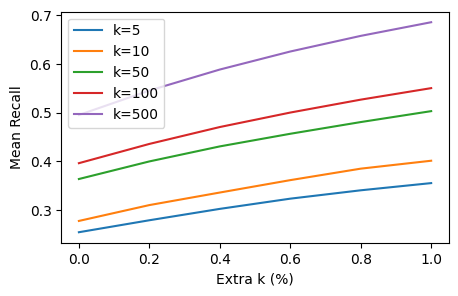

In [35]:
# plot all
fig, ax = plt.subplots(figsize=(5, 3))
for k in ks:
    ax.plot(kps, mean_recall_dict[k], label=f"k={k}")
    ax.set_xlabel("Extra k (%)")
    ax.set_ylabel("Mean Recall")
# ax.set_title("Mean recall vs. percentage of extra k")
ax.legend()
plt.show()

In [63]:
 # load pickle
g_data = pickle.load(open('../data/arxiv/graph.pickle', 'rb'))

pprint(g_data.data_dict['id_1009.5145'])
print()
print(g_data.keyword_dict['author:YonghuiLi'])

{'author:RaymondH.Y.Louie',
 'author:YonghuiLi',
 'author:andBrankaVucetic',
 'category:cs.IT',
 'category:math.IT',
 'journal:IEEE Transactions on Vehicular Technology, 2010',
 'year:2016'}

{'id_1009.5145', 'id_2106.02811'}


In [40]:
k = 10
test_k = k * 2

gt_res = vector_search(coll=gt_coll, text_queries=text_queries, k=k, batch_size=100)
test_res = vector_search(coll=test_coll, text_queries=text_queries, k=test_k, batch_size=100)

100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


In [110]:
query_idx = 10
tmp_sample = test_res[query_idx]

mg = MetadataGraph()
metadata_sets = []
for id in tmp_sample:
    metadata_sets.append(g_data.data_dict[id])

mg.build_from_metadata_set_list(metadata_sets)

In [111]:
dc = nx.degree_centrality(mg.G)

# sort by degree centrality
sorted_dc = dict(sorted(dc.items(), key=lambda x: x[1], reverse=True))
# sorted_dc

In [112]:
dp_meta_score = {}
for dp_id in tmp_sample:
    # print(dp)
    metadata = g_data.data_dict[dp_id]
    # compute metadata score (avg degree centrality of metadata)
    dp_meta_score[dp_id] = np.mean([dc[md] for md in metadata])

In [124]:
print("precent include")
print("before  :", compute_percent_include(gt_res[0], tmp_sample[:10]))

# re-rank by metadata score
sorted_dp_meta_score = dict(sorted(dp_meta_score.items(), key=lambda x: x[1], reverse=True))
re_ranked_dps = list(sorted_dp_meta_score.keys())

print("re-rank :", compute_percent_include(gt_res[query_idx], re_ranked_dps[:10]))

print("upper-bound:", compute_percent_include(gt_res[query_idx], re_ranked_dps[:]))

precent include
before  : 0.0
re-rank : 0.1
upper-bound: 0.2
